# <a id='toc1_'></a>[**Classify Waste Products Using Transfer Learning**](#toc0_)


In [ ]:
!pip install tensorflow==2.17.0 | tail -n 1
!pip install numpy==1.24.3 | tail -n 1
!pip install scikit-learn==1.5.1  | tail -n 1
!pip install matplotlib==3.9.2  | tail -n 1

### <a id='toc1_3_2_'></a>[Importing Required Libraries](#toc0_)


In [5]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


Transfer learning** uses the concept of keeping the early layers of a pre-trained network, and re-training the later layers on a specific dataset. You can leverage some state of that network on a related task.


In [ ]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

In [17]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42



Image data generators create batches of tensor image data with real-time data augmentation. The generators loop over the data in batches and are useful in feeding data to the training process. 



In [13]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [14]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [15]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


In [19]:

# Create an image data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the test generator
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)




Found 200 images belonging to 2 classes.


Let's look at a few augmented images:


In [ ]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


### <a id='toc1_8_1_'></a>[Pre-trained Models](#toc0_)

Pre-trained models are saved networks that have previously been trained on some large datasets. They are typically used for large-scale image-classification task. They could be customized to a given task using transfer learning. 






In [23]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We flatten the output of a vgg model and assign it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference .
With the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [24]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next, you freeze the basemodel.


In [25]:
for layer in basemodel.layers: 
    layer.trainable = False

Create a new model on top. You add a Dropout layer for regularization, only these layers will change as for the lower layers you set `training=False` when calling the base model.


In [26]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [27]:
 print the summary of the model
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [28]:
for layer in basemodel.layers: 
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)


You will use early stopping to avoid over-training the model.


In [30]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

## <a id='toc1_11_'></a>[Fit and train the model](#toc0_)


In [31]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=5, 
                               epochs=10,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               validation_steps=val_generator.samples // batch_size, 
                               verbose=1)

Epoch 1/10
lr: 9.048374180359596e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4502 - loss: 0.8604 
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 12s/step - accuracy: 0.4543 - loss: 0.8537 - val_accuracy: 0.7083 - val_loss: 0.5995 - learning_rate: 1.0000e-04
Epoch 2/10
lr: 8.187307530779819e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7735 - loss: 0.5773 
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - accuracy: 0.7623 - loss: 0.5820 - val_accuracy: 0.7865 - val_loss: 0.5324 - learning_rate: 9.0484e-05
Epoch 3/10
lr: 7.408182206817179e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7551 - loss: 0.5379 
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - accuracy: 0.7615 - loss: 0.5324 - val_accuracy: 0.7865 - val_loss: 0.4862 - learning_rate: 8.1873e-05
Epoch 4/10
lr: 6.703200460356393e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8007 - loss: 0.5168 
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.7933 - loss: 0.5202 - val_accuracy: 0.8229 - val_loss: 0.4432 - learning_rate: 7.4082e-05
Epoch 5/10
lr: 6.065306597126335e-05━━━━━━━━━━━━ 0s 

### <a id='toc1_11_1_'></a>[Plot loss curves for training and validation sets (extract_feat_model)](#toc0_)


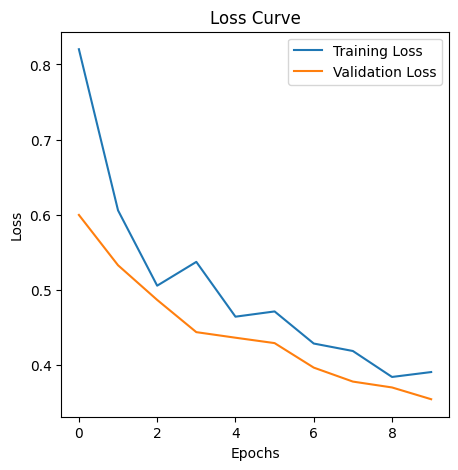

In [32]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

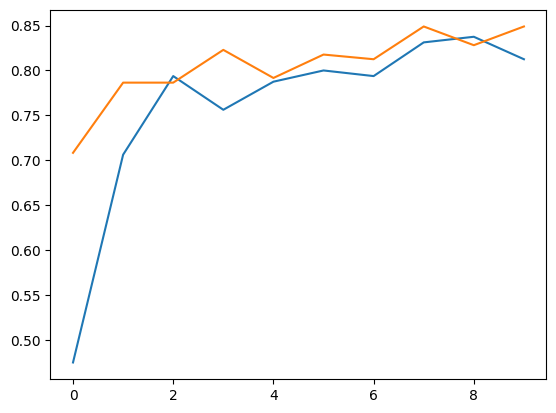

In [33]:
import matplotlib.pyplot as plt

history = extract_feat_model
## Task 6: Plot accuracy curves for training and validation sets
figsize=(5, 5)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
Title: 'Accuracy Curve'
xlabel: 'Epochs'
ylabel: 'Accuracy'


## <a id='toc1_12_'></a>[Fine-Tuning model](#toc0_)

Fine-tuning is an optional step in transfer learning, it usually ends up improving the performance of the model. 

You will **unfreeze** one layer from the base model and train the model again.


In [34]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


Similar to what you did before, you will create a new model on top, and add a Dropout layer for regularization.


In [35]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
lr: 9.048374180359596e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5980 - loss: 0.7632 
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 11s/step - accuracy: 0.6004 - loss: 0.7575 - val_accuracy: 0.7344 - val_loss: 0.5511 - learning_rate: 1.0000e-04
Epoch 2/10
lr: 8.187307530779819e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6472 - loss: 0.5780 
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.6529 - loss: 0.5751 - val_accuracy: 0.8438 - val_loss: 0.4458 - learning_rate: 9.0484e-05
Epoch 3/10
lr: 7.408182206817179e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8110 - loss: 0.4375 
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - accuracy: 0.8092 - loss: 0.4385 - val_accuracy: 0.6354 - val_loss: 0.5975 - learning_rate: 8.1873e-05
Epoch 4/10
lr: 6.703200460356393e-05━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8039 - loss: 0.4499 
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - accuracy: 0.8063 - loss: 0.4454 - val_accuracy: 0.7708 - val_loss: 0.4450 - learning_rate: 7.4082e-05
Epoch 5/10
lr: 6.065306597126335e-05━━━━━━━━━━━━ 0s 

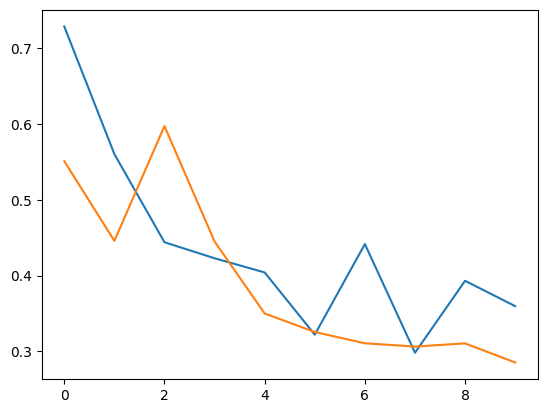

In [36]:
history = fine_tune_model

 Plot loss curves for training and validation sets (fine tune model)
history = fine_tune_model
figsize=(5, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
Title: 'Loss Curve'
xlabel: 'Epochs'
ylabel: 'Loss'



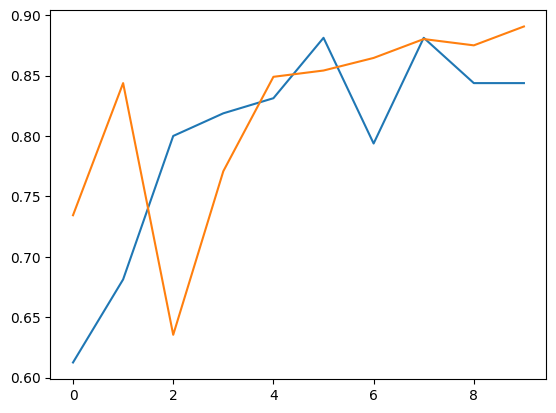

In [37]:
history = fine_tune_model

Plot accuracy curves for training and validation sets  (fine tune model)
history = fine_tune_model
figsize=(5, 5)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
Title: 'Accuracy Curve'
xlabel: 'Epochs'
ylabel: 'Accuracy'

In [38]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.76      0.88      0.81        50
           R       0.86      0.72      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.79      0.84      0.82        50
           R       0.83      0.78      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



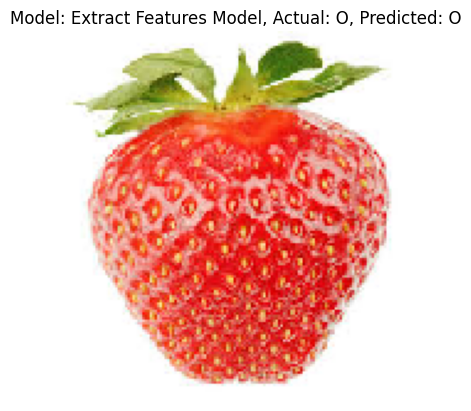

In [39]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

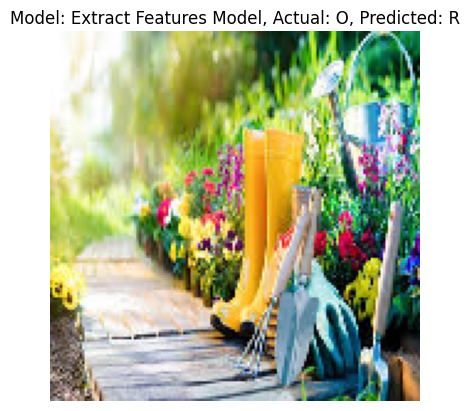

In [40]:
Plot a test image using Extract Features Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

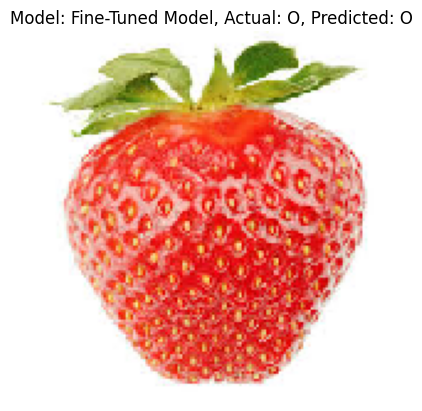

In [41]:
Plot a test image using Fine-Tuned Model (index_to_plot = 1)
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )